<a href="https://colab.research.google.com/github/EslamElsolia5/DL-Projects/blob/main/Human_Action_Recognition_(HAR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HAR Classification
---
By: "Eslam"

###1- Importing Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

###2- Reading our data
---

In [3]:
data = pd.read_csv("/content/Heterogeneous_accelerometer_HAR.csv")
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [4]:
data.shape

(3540962, 10)

Our dataset contains approximately 3,500,000 rows. Each row contains information from which we can predict human action.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540962 entries, 0 to 3540961
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Index          int64  
 1   Arrival_Time   int64  
 2   Creation_Time  int64  
 3   x              float64
 4   y              float64
 5   z              float64
 6   User           object 
 7   Model          object 
 8   Device         object 
 9   gt             object 
dtypes: float64(3), int64(3), object(4)
memory usage: 270.2+ MB


###3- Null values
---

In [6]:
data.isna().any()

,0
Index,False
Arrival_Time,False
Creation_Time,False
x,False
y,False
z,False
User,False
Model,False
Device,False
gt,True


In [7]:
data[["y", "z", "gt"]].isna().sum()

,0
y,0
z,0
gt,520357


The target "gt" contains a lot of missing data (approximately half a million piece of data) so I decided to delete these rows and it won't affect the prediction.

In [8]:
data.dropna(inplace = True)

In [9]:
data.shape

(3020605, 10)

###4- Data processing
---

I will extract from the data only four columns ("x", "y", "z", and the target "gt").

The features "x", "y", "z" are the information of the sensor along x axis, y axis and z axis, so we will agnore the rest of the features.

In [10]:
newData = data[["x", "y", "z", "gt"]]
newData

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand
...,...,...,...,...
3540957,4.416595,-8.708023,-1.715271,bike
3540958,5.337799,-9.526871,-1.222534,bike
3540959,6.580353,-9.748245,-1.291565,bike
3540960,7.932404,-9.514969,-1.608154,bike


In [11]:
newData["gt"].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [12]:
newData["gt"].value_counts()

,count
gt,
bike,635530
walk,549761
stairsdown,486376
stairsup,473754
stand,451189
sit,423995


In [13]:
# Select randomly few examples for each class as dataframes
# ---------------------------------------
bike = newData[newData["gt"] == "bike"].sample(n = 5000)
walk = newData[newData["gt"] == "walk"].sample(n = 5000)
stairsdown = newData[newData["gt"] == "stairsdown"].sample(n = 5000)
stairsup = newData[newData["gt"] == "stairsup"].sample(n = 5000)
stand = newData[newData["gt"] == "stand"].sample(n = 5000)
sit = newData[newData["gt"] == "sit"].sample(n = 5000)

In [14]:
# Concatenate these dataframes
# -----------------------------
har_data = pd.concat([bike, walk, stairsdown, stairsup, stand, sit])
har_data

,x,y,z,gt
947375,-6.699478,-4.835602,6.747543,bike
1396797,4.847702,-4.035797,7.033188,bike
992836,-7.956314,-2.338592,4.533798,bike
3025845,-6.851822,-6.366180,6.023911,bike
1418180,5.114304,-6.254303,7.754440,bike
...,...,...,...,...
2727931,1.458054,-7.499237,6.323837,sit
9326,-7.621343,-5.428254,2.916736,sit
2742210,4.274033,2.243622,7.352158,sit
655172,3.136215,-8.715607,2.815170,sit


In [15]:
# Encoding the classes
# ---------------------
LE = LabelEncoder()
har_data["gt"] = LE.fit_transform(har_data["gt"])

In [16]:
har_data = har_data.reset_index(drop = True)
har_data

,x,y,z,gt
0,-6.699478,-4.835602,6.747543,0
1,4.847702,-4.035797,7.033188,0
2,-7.956314,-2.338592,4.533798,0
3,-6.851822,-6.366180,6.023911,0
4,5.114304,-6.254303,7.754440,0
...,...,...,...,...
29995,1.458054,-7.499237,6.323837,1
29996,-7.621343,-5.428254,2.916736,1
29997,4.274033,2.243622,7.352158,1
29998,3.136215,-8.715607,2.815170,1


###5- Feature Extration
---

I used the features and the target before extracting new features to build a neural network that was able to predict the action with 62% accuracy in both training and testing. So I improved that by adding new features (12 features) from the existing features using the window function technique.

In [17]:
X_min = []
X_max = []
X_mean = []
X_std = []

Y_min = []
Y_max = []
Y_mean = []
Y_std = []

Z_min = []
Z_max = []
Z_mean = []
Z_std = []

labels = []

X = har_data["x"].values
Y = har_data["y"].values
Z = har_data["z"].values
label = har_data["gt"].values
window = 256
for i in range(len(label) - window):
  X_min.append(np.min(X[i:i+window]))
  X_max.append(np.max(X[i:i+window]))
  X_mean.append(np.mean(X[i:i+window]))
  X_std.append(np.std(X[i:i+window]))

  Y_min.append(np.min(Y[i:i+window]))
  Y_max.append(np.max(Y[i:i+window]))
  Y_mean.append(np.mean(Y[i:i+window]))
  Y_std.append(np.std(Y[i:i+window]))

  Z_min.append(np.min(Z[i:i+window]))
  Z_max.append(np.max(Z[i:i+window]))
  Z_mean.append(np.mean(Z[i:i+window]))
  Z_std.append(np.std(Z[i:i+window]))

  labels.append(label[i+window]) # The label of the last row in each window

har_data_new = pd.DataFrame({"X_min" : X_min, "X_max" : X_max, "X_mean" : X_mean, "X_std" : X_std,
                             "Y_min" : Y_min, "Y_max" : Y_max, "Y_mean" : Y_mean, "Y_std" : Y_std,
                             "Z_min" : Z_min, "Z_max" : Z_max, "Z_mean" : Z_mean, "Z_std" : Z_std,
                             "labels" : labels})
har_data_new


,X_min,X_max,X_mean,X_std,Y_min,Y_max,Y_mean,Y_std,Z_min,Z_max,Z_mean,Z_std,labels
0,-19.084549,13.445602,-1.439018,6.866524,-17.208770,9.447067,-2.592795,4.578801,-6.111816,10.729904,4.572525,3.450588,0
1,-19.084549,14.183517,-1.357443,6.927321,-17.208770,9.447067,-2.571539,4.580970,-6.111816,10.729904,4.579313,3.456564,0
2,-19.084549,14.183517,-1.350852,6.934022,-17.208770,9.447067,-2.574857,4.582337,-6.111816,10.729904,4.574801,3.454111,0
3,-19.084549,14.183517,-1.352163,6.935302,-17.208770,9.447067,-2.591678,4.589336,-6.111816,10.729904,4.562610,3.459736,0
4,-19.084549,14.183517,-1.368379,6.952974,-17.208770,9.447067,-2.569696,4.584679,-6.111816,10.729904,4.552289,3.459302,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29739,-9.796341,9.098785,0.437724,4.134550,-9.936737,8.994354,-5.138408,5.507874,-2.766800,9.746811,3.853526,2.884924,1
29740,-9.796341,9.098785,0.435521,4.133855,-9.936737,8.994354,-5.139273,5.508227,-2.766800,9.746811,3.852866,2.884339,1
29741,-9.796341,9.098785,0.437629,4.129606,-9.936737,8.994354,-5.139180,5.508222,-2.766800,9.746811,3.856099,2.882824,1
29742,-9.796341,9.098785,0.448638,4.136057,-9.936737,8.994354,-5.101549,5.525597,-2.766800,9.746811,3.859139,2.886097,1


###6- Building A Neural Network
---

In [18]:
X = har_data_new.drop("labels", axis = 1).values
y = har_data_new["labels"].values

In [19]:
print(X.shape)
print(y.shape)

(29744, 12)
(29744,)


In [20]:
har_data_new["labels"].value_counts()

,count
labels,
5,5000
2,5000
3,5000
4,5000
1,5000
0,4744


In [21]:
# Splitting the data
# --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
# Converting the numpy data into tensor data
# --------------------------------------------
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

In [23]:
# Combine the Features & Label tensors for both training and testing set
# -----------------------------------------------------------------------
X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)
X_y_test.tensors[0].shape[0]

5949

In [24]:
# Splitting data into batches
# ------------------------------
train_loader = DataLoader(X_y_train, batch_size = 64, shuffle = True, drop_last= True)
test_loader  = DataLoader(X_y_test, batch_size = X_y_test.tensors[0].shape[0])

In [25]:
# Building our NN Model with 3 hidden layers
# -------------------------------------------
NNModel = nn.Sequential(
    nn.Linear(12, 64),      # The first hidden layer consists of 64 neurons
    nn.ReLU(),
    nn.Linear(64, 32),      # The second hidden layer consists of 32 neurons
    nn.ReLU(),
    nn.Linear(32, 16),      # The third hidden layer consists of 16 neurons
    nn.ReLU(),
    nn.Linear(16, 6),
)
NNModel

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=6, bias=True)
)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(NNModel.parameters(),momentum = 0.9, lr=.001)

In [34]:
# Training & Testing process
# ---------------------------
NNModel.to(device)
epochs = 101
train_acc = []
train_loss = []
test_acc = []

for epoch in range(epochs):
  NNModel.train()       # Training mode

  batch_acc = []
  batch_loss = []
  for X, y in train_loader:
    X, y = X.to(device), y.to(device)

    y_pred = NNModel(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss.append(loss.item())
    y_pred = y_pred.cpu()
    y = y.cpu()
    batch_acc.append(torch.mean((torch.argmax(y_pred, dim = 1) == y).float()))

  train_loss.append(np.mean(batch_loss))
  train_acc.append(np.mean(batch_acc))

  NNModel.eval()             # Testing mode
  test_correct = 0
  test_total = 0

  with torch.no_grad():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      y_pred = NNModel(X)

      test_correct += (torch.argmax(y_pred, dim = 1) == y).sum().item()
      test_total += y.shape[0]
      y_pred = y_pred.cpu()
      y = y.cpu()

    test_acc.append(test_correct / test_total)

  if epoch % 20 == 0:
    print(f"Epoch #{epoch} => Loss :              {loss.item()}\
                        Training accuracy : {train_acc[-1]:.2f}\
                        Testing accuract  : {test_acc[-1]:.2f}")

Epoch #0 => Loss :              0.27746137976646423                        Training accuracy : 0.83                        Testing accuract  : 0.94
Epoch #20 => Loss :              0.11109010875225067                        Training accuracy : 0.97                        Testing accuract  : 0.97
Epoch #40 => Loss :              0.14787068963050842                        Training accuracy : 0.98                        Testing accuract  : 0.96
Epoch #60 => Loss :              0.03411034494638443                        Training accuracy : 0.98                        Testing accuract  : 0.99
Epoch #80 => Loss :              0.02938755415380001                        Training accuracy : 0.98                        Testing accuract  : 0.99
Epoch #100 => Loss :              0.0030539745930582285                        Training accuracy : 0.99                        Testing accuract  : 0.99


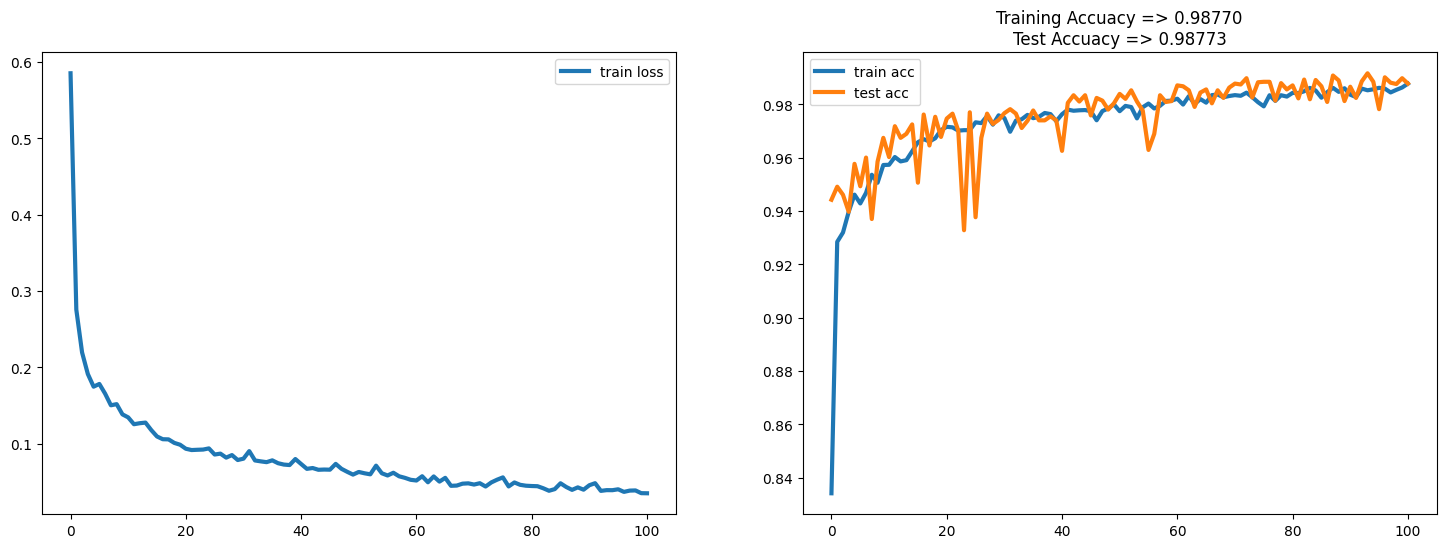

In [39]:
plt.subplots(1, 2, figsize = (18, 6))

plt.subplot(1,2,1)
plt.plot(train_loss, label = "train loss", lw = 3)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label = "train acc", lw =3)
plt.plot(test_acc, label = "test acc", lw =3)
plt.title(f"Training Accuacy => {train_acc[-1]:.5f}\nTest Accuacy => {test_acc[-1]:.5f}")
plt.legend()

plt.show()

In [56]:
y_pred = NNModel(X)
y_pred = torch.argmax(y_pred, dim = 1).cpu()
print(y_pred[:10])
print(y[:10])

tensor([3, 1, 3, 2, 1, 2, 4, 4, 4, 5])
tensor([3, 1, 3, 2, 1, 2, 4, 4, 4, 5])


In [57]:
# Save the model
torch.save(NNModel.state_dict(), "NNModel.pt")